# Reactor Physics Data Set

**Inputs**: 2-group homogenized cross sections (HXS)

- `FissionFast`: $\nu\Sigma_f^1$
- `CaptureFast`: $\Sigma_a^1$
- `FissionThermal`: $\nu\Sigma_f^2$
- `CaptureThermal`: $\Sigma_a^2$
- `Scatter12`: $\Sigma_s^{1 \rightarrow 2}$
- `Scatter11`: $\Sigma_s^{1 \rightarrow 1}$
- `Scatter21`: $\Sigma_s^{2 \rightarrow 1}$
- `Scatter22`: $\Sigma_s^{2 \rightarrow 2}$

**Outputs**

- `k`: Neutron multipulcation factor

This data set consists of 1000 observations with 8 inputs and 1 output. The data is taken from [1], a sensitivity analysis using the Shapley effect. The geometry of the problem is a pressurized water reactor (PWR) lattice based on the BEAVRS benchmark. The lattice is a $17 \times 17$ PWR with 264 $UO_2$ fuel rods, 24 guide tubes, and one instrumentation tube. The lattice utilizes quarter symmetry in TRITON and is depleted to 50 GWD/MTU. To construct the data set a two-step process was used: (1) the uncertainty in the fundamental microscopic XS data was propogated and (2) these XSs were collapsed into a 2-group form using the following equation

\begin{equation}
    \Sigma_x^g = \frac{\int_{\Delta E_g}dE \int_V \Sigma_{x,m}(E) \phi(r,E,t) dV}{\int_{\Delta E_g}dE\int_V\phi(r,E,t)dV}.
\end{equation}

The Sampler module in SCALE was used for uncertainty propagation and the 56-group XS and covariance libraries were used in TRITON to create 56-group HXSs using the above equation. These HXSs are then collapsed to a 2-group library. 1000 random samples were taken from the Sampler.

In [6]:
import pyMAISE as mai
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import uniform, randint
from sklearn.model_selection import ShuffleSplit

# Plot settings
matplotlib_settings = {
    "font.size": 14,
    "legend.fontsize": 12,
}
plt.rcParams.update(**matplotlib_settings)
%load_ext autoreload
%autoreload 2

## pyMAISE Initialization

pyMAISE will be initialized with the following global settings:

- `verbosity`: 0,
- `random_state`: None,
- `test_size`: 0.3,
- `num_configs_saved`: 5.

In [2]:
settings = {
    "verbosity": 0,
    "random_state": None,
    "test_size": 0.3,
    "num_configs_saved": 5,
}
global_settings = mai.settings.init(settings_changes=settings)

## Data Loading and Pre-processing

As this is a provided benchmark data set, we can load the preprocessor using `load_xs()`.

In [3]:
preprocessor = mai.load_xs()

The data consists of 8 inputs

In [4]:
preprocessor.inputs.head()

,FissionFast,CaptureFast,FissionThermal,CaptureThermal,Scatter12,Scatter11,Scatter21,Scatter22
0,0.006446,0.009248,0.130007,0.080836,0.014973,0.482483,0.001506,1.12546
1,0.006359,0.009347,0.128811,0.081048,0.015363,0.490558,0.001497,1.12616
2,0.006467,0.009253,0.129465,0.080762,0.015198,0.486784,0.001493,1.12423
3,0.006479,0.009258,0.130903,0.081478,0.015345,0.492895,0.001516,1.13075
4,0.006431,0.009248,0.129757,0.081129,0.015216,0.488249,0.001506,1.12731


and one output.

In [5]:
preprocessor.outputs.head()

,k
0,1.256376
1,1.241534
2,1.256988
3,1.261442
4,1.253744


To get a better idea of the data we can create a corrilation matrix using the `correlation_matrix()` function.

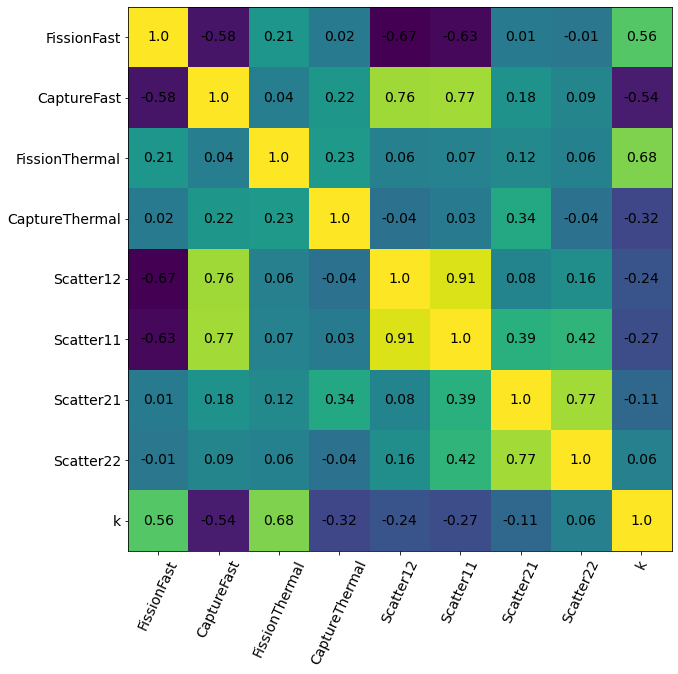

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
fig, ax = preprocessor.correlation_matrix(fig=fig, ax=ax, colorbar=False, annotations=True)

The last step of initialization is scaling, we will min-max scale this data.

In [8]:
data = preprocessor.min_max_scale()

## Model Initialization

As this data set had a 1-dimensional output, we will hyper-parameter 7 models:

- Linear regression: `linear`,
- Lasso regression: `lasso`,
- Support vector regression: `svr`,
- Decision tree regression: `dtree`,
- Random forest regression: `rforest`,
- K-nearest neighbors regression: `knn`,
- Sequential Dense Neural Networks: `nn`.

All the classical models are initialized with the Scikit-learn defaults; however, the neural networks require some paramter definitions.

In [9]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "svr", "knn", "rforest", "nn"],
    "nn": {
        # Sequential
        "num_layers": 2,
        "dropout": True,
        "rate": 0.5,
        "validation_split": 0.15,
        "loss": "mean_absolute_error",
        "metrics": "mean_absolute_error",
        "batch_size": 8,
        "epochs": 50,
        # Starting Layer
        "start_num_nodes": 100,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": 8,
        # Middle Layers
        "mid_num_node_strategy": "linear",  # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": 1,  # Number of outputs
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 8e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

## Hyper-parameter Tuning

They hyper-parameter tuning space is defined below. 

In [10]:
random_search_dist = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "svr": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 2 - 20
        "max_features": [None, 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=3, high=20), # 3 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=5, high=30), # 5 - 30
        "p": randint(low=2, high=10), # 2 - 10
    },
}
bayesian_search_limits = {
    "nn": {
        "batch_size": [8, 64],
        "learning_rate": [1e-5, 0.001],
        "num_layers": [2, 6],
        "start_num_nodes": [50, 200],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_distributions=random_search_dist, 
    models=["linear"] + list(random_search_dist.keys()), 
    n_iter=300, 
    cv=ShuffleSplit(n_splits=10, test_size=0.15, random_state=settings["random_state"]),
)
bayesian_search_configs = tuning.bayesian_search(
    search_spaces=bayesian_search_limits,
    models=bayesian_search_limits.keys(),
    n_iter=30,
    cv=[(slice(None), slice(None))],
)
stop = time.time()
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning search space was not provided for linear, doing manual fit


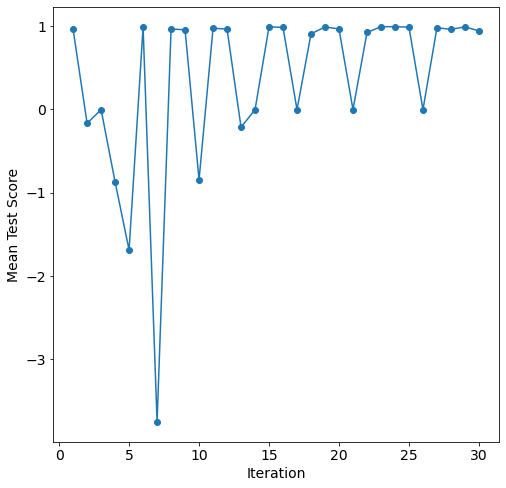

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(models="nn")

In [13]:
new_model_settings = {
    "nn": {"epochs": 200}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings
)

In [14]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
27,nn,"{'batch_size': 16, 'learning_rate': 0.001, 'nu...",0.994945,0.008808,0.000148,0.012176,0.686122,0.097349,0.009748,0.098734
26,nn,"{'batch_size': 15, 'learning_rate': 0.00097193...",0.982206,0.020730,0.000522,0.022843,0.683624,0.096065,0.009826,0.099127
5,lasso,{'alpha': 0.0001822506888573135},0.999386,0.003375,0.000018,0.004245,0.675433,0.099313,0.010080,0.100402
4,lasso,{'alpha': 0.00017227113656984218},0.999443,0.003211,0.000016,0.004042,0.675016,0.099363,0.010093,0.100466
3,lasso,{'alpha': 0.00014439419071893872},0.999586,0.002766,0.000012,0.003483,0.673828,0.099500,0.010130,0.100650
2,lasso,{'alpha': 0.0001256688386070433},0.999668,0.002472,0.000010,0.003118,0.673010,0.099593,0.010156,0.100776
1,lasso,{'alpha': 0.00011385146538117281},0.999714,0.002290,0.000008,0.002894,0.672486,0.099651,0.010172,0.100856
0,linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.999935,0.000987,0.000002,0.001382,0.667630,0.100139,0.010323,0.101601
29,nn,"{'batch_size': 15, 'learning_rate': 0.00092371...",0.998990,0.004047,0.000030,0.005443,0.658862,0.101640,0.010595,0.102933
25,knn,"{'leaf_size': 20, 'n_neighbors': 5, 'p': 3, 'w...",1.000000,0.000000,0.000000,0.000000,0.657039,0.088734,0.010652,0.103207


In [28]:
for model in model_settings["models"]:
    print(postprocessor.get_params(model_type=model), "\n")

  Model Types  copy_X  fit_intercept n_jobs   normalize  positive
0      linear    True           True   None  deprecated     False 

  Model Types     alpha
0       lasso  0.000107 

  Model Types  max_depth max_features  min_samples_leaf  min_samples_split
0       dtree         16         None                 2                  6 

  Model Types  degree  gamma kernel
0         svr       2  scale   poly 

  Model Types  leaf_size  n_neighbors  p   weights
0         knn         23            6  5  distance 

  Model Types criterion  max_features  min_samples_leaf  min_samples_split  \
0     rforest   poisson             6                 1                  3   

   n_estimators  
0           160   

  Model Types  batch_size  learning_rate  num_layers  start_num_nodes
0          nn          10          0.001           2              200 



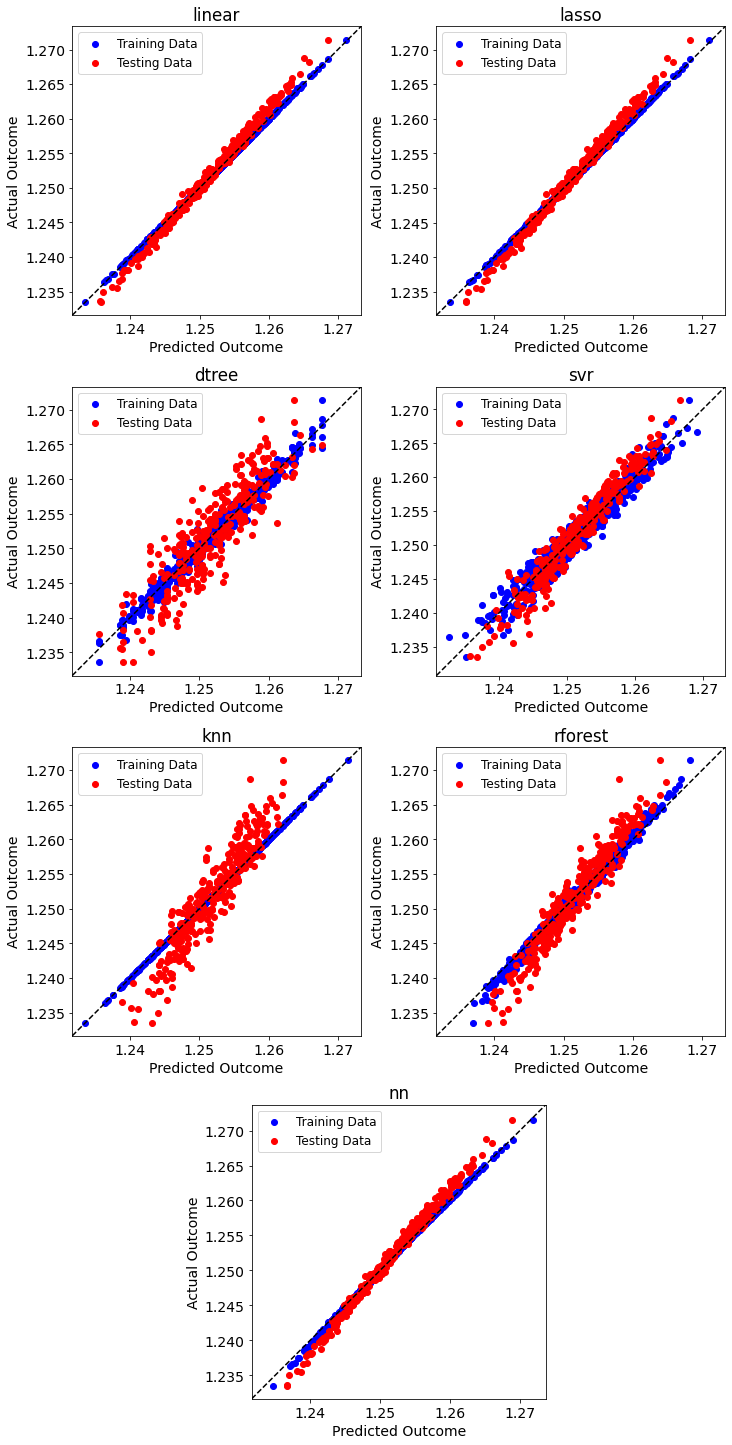

In [29]:
models = np.array([["linear", "lasso"], ["dtree", "svr"], ["knn", "rforest"], ["nn", None]])

fig = plt.figure(constrained_layout=fig, figsize=(10,20))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0] - 1):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.diagonal_validation_plot(model_type=models[i, j], yscaler=preprocessor.yscaler)
            ax.set_title(models[i, j])
ax = fig.add_subplot(gs[-1, :])
ax = postprocessor.diagonal_validation_plot(model_type=models[-1, 0], yscaler=preprocessor.yscaler)
_ = ax.set_title(models[-1, 0])

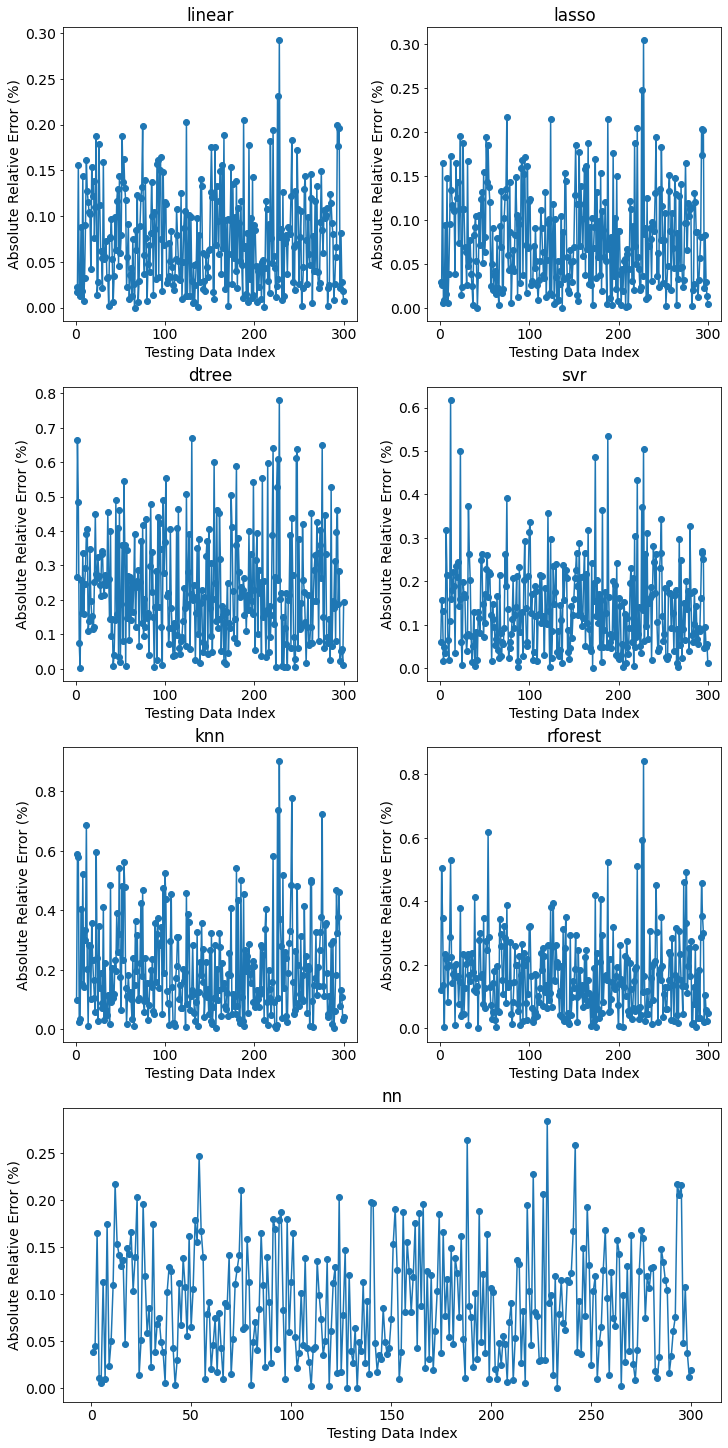

In [30]:
fig = plt.figure(constrained_layout=fig, figsize=(10,20))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0] - 1):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.validation_plot(model_type=models[i, j], yscaler=preprocessor.yscaler)
            ax.set_title(models[i, j])
ax = fig.add_subplot(gs[-1, :])
ax = postprocessor.validation_plot(model_type=models[-1, 0], yscaler=preprocessor.yscaler)
_ = ax.set_title(models[-1, 0])

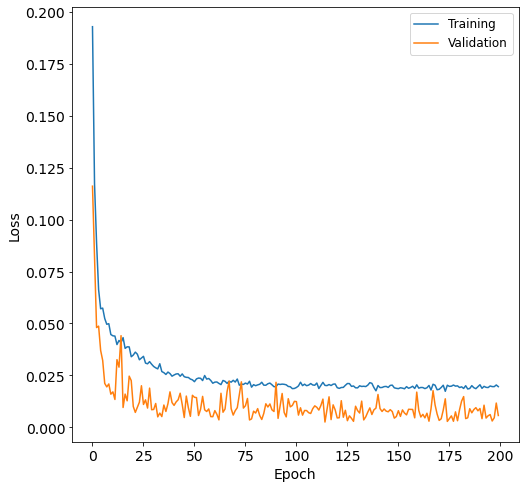

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

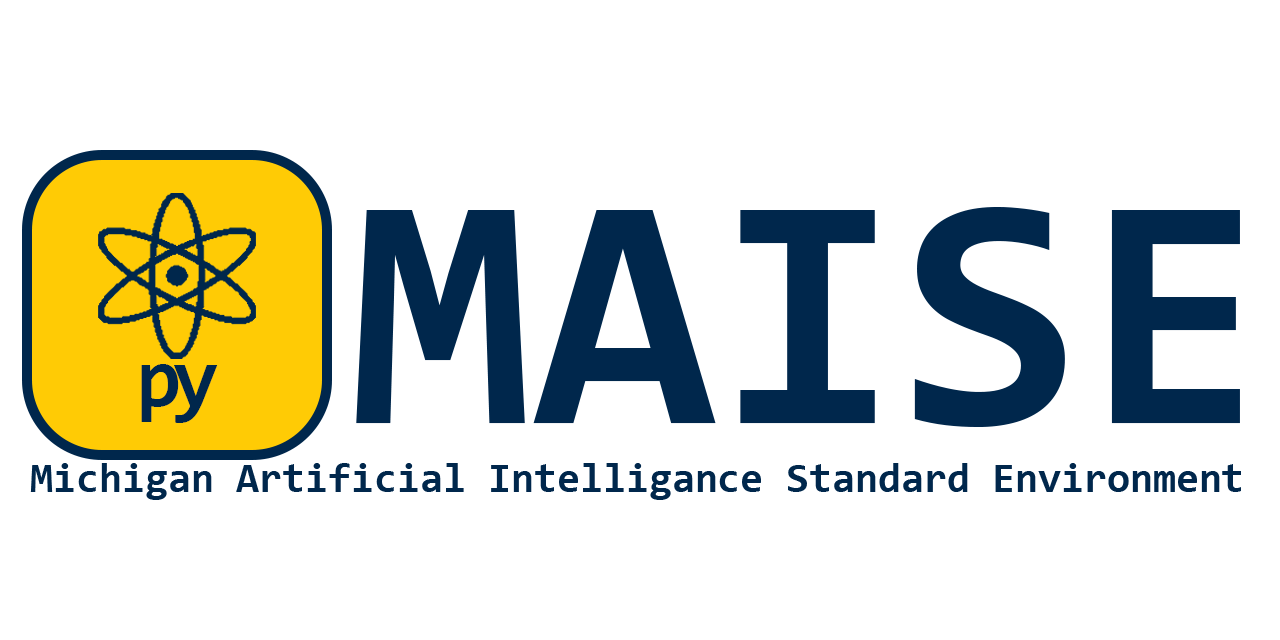